In [1]:
import response_utils
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.linalg import expm
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",  # Use a LaTeX-compatible serif font
    "font.serif": ["Computer Modern Roman"],  # Or another LaTeX font
})

%load_ext autoreload
%autoreload 2

# Experiment 2: Coupled 3 box model
## a) Forcing applied evenly into all boxes

### $\frac{\partial}{\partial t} C_i = -L_{i,j} C_i + F(t)$

In [2]:
# Grid parameters
dt = 1
Nt = 400 # Number of years
t = np.arange(0,dt*Nt,dt)
Nt = len(t)

# ODE parameters
M_a = 1
M_s = 5
M_d = 380
lam_as = 0.1
lam_sd = 0.1
gamma = 1/20
L = np.array([[-lam_as/M_a, lam_as/M_a, 0],
                [lam_as/M_s, -(lam_as + lam_sd)/M_s, lam_sd/M_s],
                [0, lam_sd/M_d, -lam_sd/M_d - gamma]])
T0 = 0 # K

# Forcing parameters
## 2xCO2 and 4xCO2 (constant forcing)
F_2xCO2 = response_utils.F_const(t, 0.05)
F_4xCO2 = response_utils.F_const(t, 0.1)

## RCP70
F_final = 0.2 # (W m^-2)
ts = 50
a_exp = F_final/np.exp(400*dt/ts)
F_exp = response_utils.F_exp(t, a_exp, ts)

## Overshoot
a_over = 0.04
b_over = 200
c_over = 42.7
F_over = response_utils.F_over(t, a_over, b_over, c_over)

## Impulse forcing
F0 = 1
F_pulse = response_utils.F_del(t, F0)
F_del = {'2xCO2':F_pulse,
         '4xCO2':F_pulse,
         'RCP370':F_pulse,
         'Overshoot':F_pulse}

## Compile all for diagnosis
F_all = {'2xCO2':F_2xCO2,
         '4xCO2':F_4xCO2,
         'RCP370':F_exp,
         'Overshoot':F_over}

# Plotting parameters
experiments = ['2xCO2','4xCO2','RCP370','Overshoot']
regions = ['Atmosphere', 'Shallow Ocean', 'Deep Ocean']
colors = ['g','r','b']

# Stochastic parameters
K = 0.5
N_ensemble = 50

# Generated perturbed ensemble
F_del_ensemble = response_utils.gen_F_ensemble(F_del, t, K, N_ensemble, experiments)
F_all_ensemble = response_utils.gen_F_ensemble(F_all, t, K, N_ensemble, experiments)

### Integrated solutions to experiments of interest

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

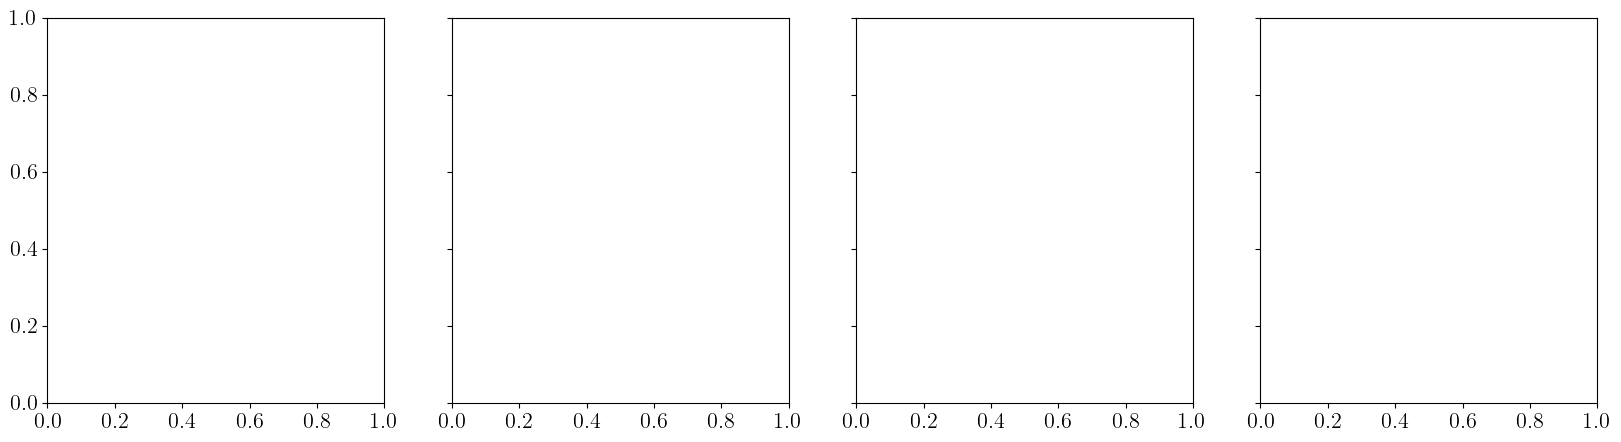

In [3]:
T_analytic, g_analytic, a_analytic = response_utils.timestep_coup(t, experiments, F_all, L, dt)
response_utils.plot_box_model(T_analytic, t, experiments, regions, colors, soln_type='Noiseless')

#### Method 1: Direct derivation of Green's function

##### a) Without noise

Error from Raw estimation.
	L2 Error, 2xCO2: 0.0
	L2 Error, 4xCO2: 0.0
	L2 Error, RCP70: 0.0
	L2 Error, Overshoot: 0.0
Avg. L2 Error: 0.0



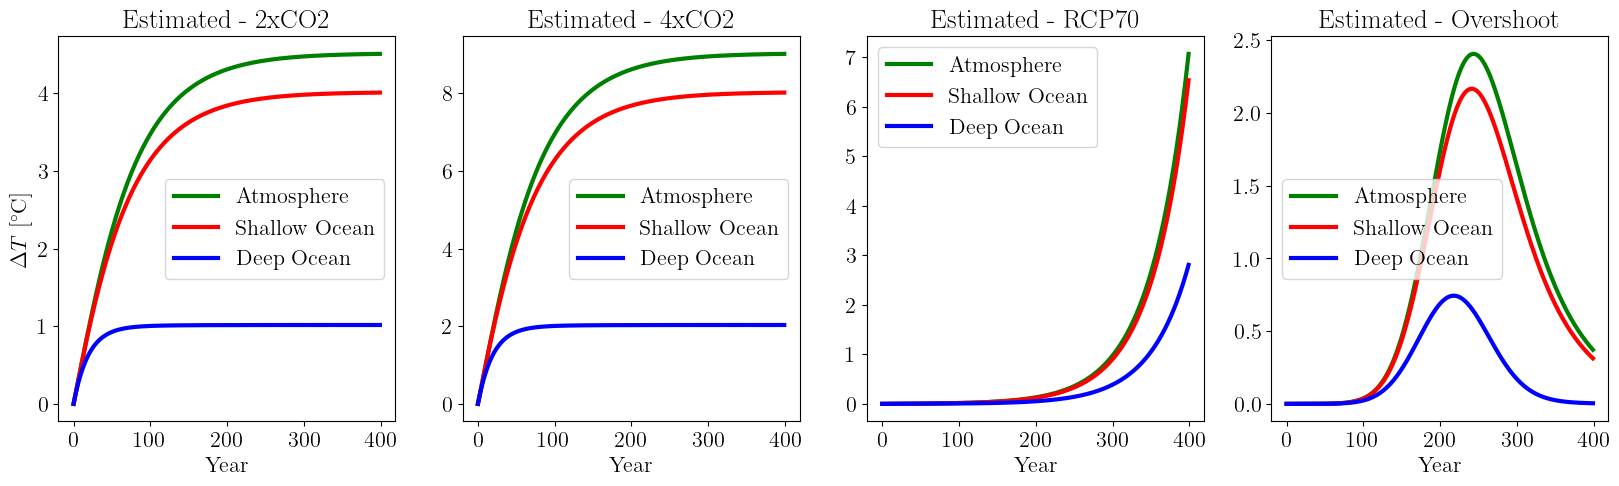

In [134]:
G_direct, g_direct, a_direct = response_utils.timestep_coup(t, experiments, F_del, L, dt)

T_est_raw_1, T_est_modal_1 = response_utils.estimate_T_2D(T_analytic, F_all,
                                                      experiments, t, 'G',
                                                      G_direct, a_direct,
                                                      g_direct, T0, dt)

response_utils.plot_box_model(T_est_raw_1, t, experiments, regions, colors, soln_type='Estimated', coupled=True)
#response_utils.plot_box_model(T_est_modal_1, t, experiments, regions, colors, soln_type='Estimated Modal', coupled=True)

L2_raw_1 = response_utils.calc_L2(T_analytic, T_est_raw_1, experiments, regions, 'Raw', coupled=True)
#L2_modal_1 = response_utils.calc_L2(T_analytic, T_est_modal_1, experiments, regions, 'Modal', coupled=True)

##### b) With noise

#### Method 2: Direct inference of L from a dataset

##### a) Without noise

Error from Raw estimation.
	L2 Error, 2xCO2: 0.06466
	L2 Error, 4xCO2: 0.12932
	L2 Error, RCP70: 0.10373
	L2 Error, Overshoot: 0.05237
Avg. L2 Error: 0.08752



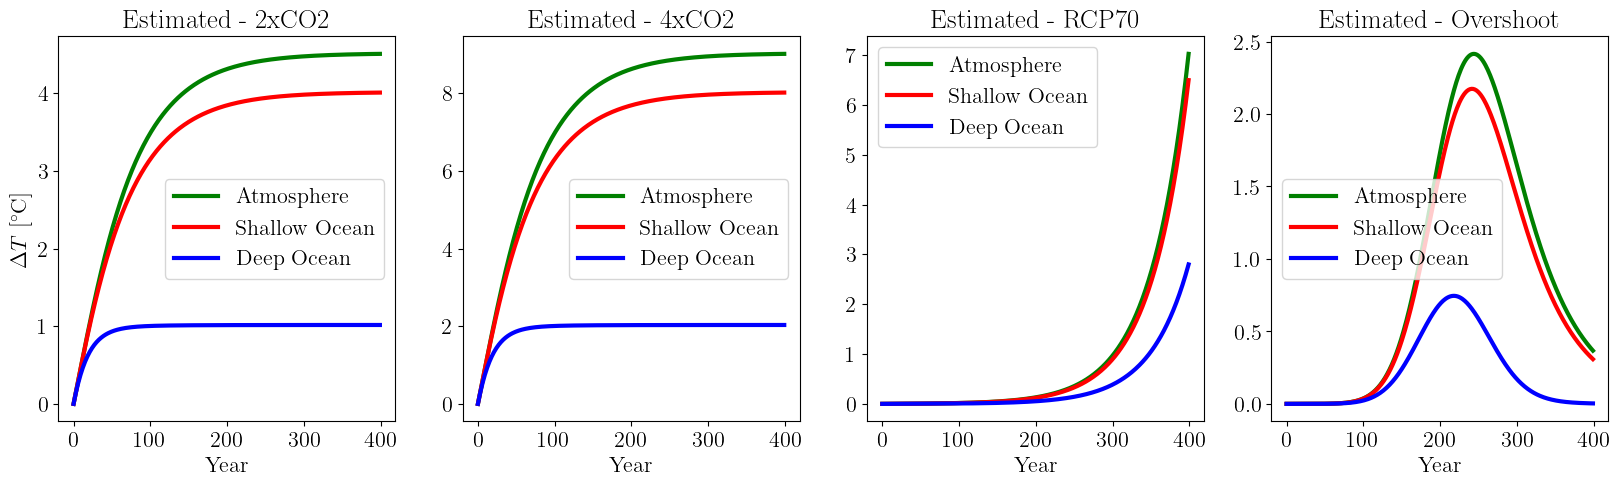

In [135]:
L_raw, L_modal = {}, {}
for exp in experiments:
  L_raw[exp] = response_utils.calc_L_direct_2D(T_analytic[exp], F_all[exp], t)
  L_modal[exp] = response_utils.calc_L_direct_2D(a_analytic[exp], F_all[exp], t, modal=True, g=g_analytic[exp])

T_est_raw_2, T_est_modal_2 = response_utils.estimate_T_2D(T_analytic, F_all,
                                                      experiments, t, 'L',
                                                      L_raw, L_modal, None,
                                                      T0, dt)

response_utils.plot_box_model(T_est_raw_2, t, experiments, regions, colors, soln_type='Estimated', coupled=True)
#response_utils.plot_box_model(T_est_modal_2, t, experiments, regions, colors, soln_type='Estimated Modal', coupled=True)

L2_raw_2 = response_utils.calc_L2(T_analytic, T_est_raw_2, experiments, regions, 'Raw', coupled=True)
#L2_modal_2 = response_utils.calc_L2(T_analytic, T_est_modal_2, experiments, regions, 'Modal', coupled=True)

##### b) With noise

#### Method 3: Direct deconvolution of response function from dataset

##### a) Without noise

Error from Raw estimation.
	L2 Error, 2xCO2: 0.0
	L2 Error, 4xCO2: 0.0
	L2 Error, RCP70: 0.0
	L2 Error, Overshoot: 0.0
Avg. L2 Error: 0.0



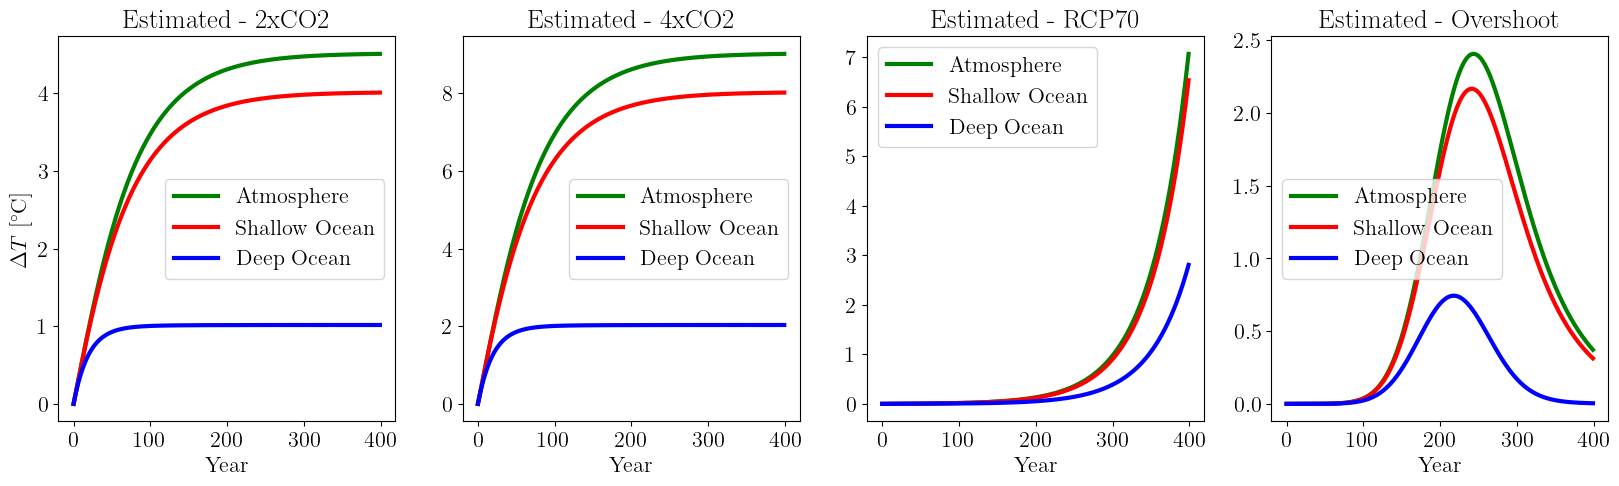

In [7]:
G_deconv, g_deconv, a_deconv = {}, {}, {}
for exp in experiments:
    G_deconv[exp] = response_utils.calc_G_deconv_2D(T_analytic[exp], F_all[exp], dt=1)
    g_deconv[exp], a_deconv[exp] = response_utils.calc_modes_2D(G_deconv[exp])

T_est_raw_3, T_est_modal_3 = response_utils.estimate_T_2D(T_analytic, F_all,
                                                      experiments, t, 'G',
                                                      G_deconv, a_deconv,
                                                      g_deconv, T0, dt)

response_utils.plot_box_model(T_est_raw_3, t, experiments, regions, colors, soln_type='Estimated', coupled=True)
#response_utils.plot_box_model(T_est_modal_3, t, experiments, regions, colors, soln_type='Estimated Modal', coupled=True)

L2_raw_3 = response_utils.calc_L2(T_analytic, T_est_raw_3, experiments, regions, 'Raw', coupled=True)
#L2_modal_3 = response_utils.calc_L2(T_analytic, T_est_modal_3, experiments, regions, 'Modal', coupled=True)

##### b) With noise

#### Method 4: Estimation of response function using only leading timescales

##### a) Without noise

##### a.i) Single leading order timescale

Error from Raw estimation.
	L2 Error, 2xCO2: 1.48671
	L2 Error, 4xCO2: 2.97343
	L2 Error, RCP70: 0.00144
	L2 Error, Overshoot: 1.16802
Avg. L2 Error: 1.4074



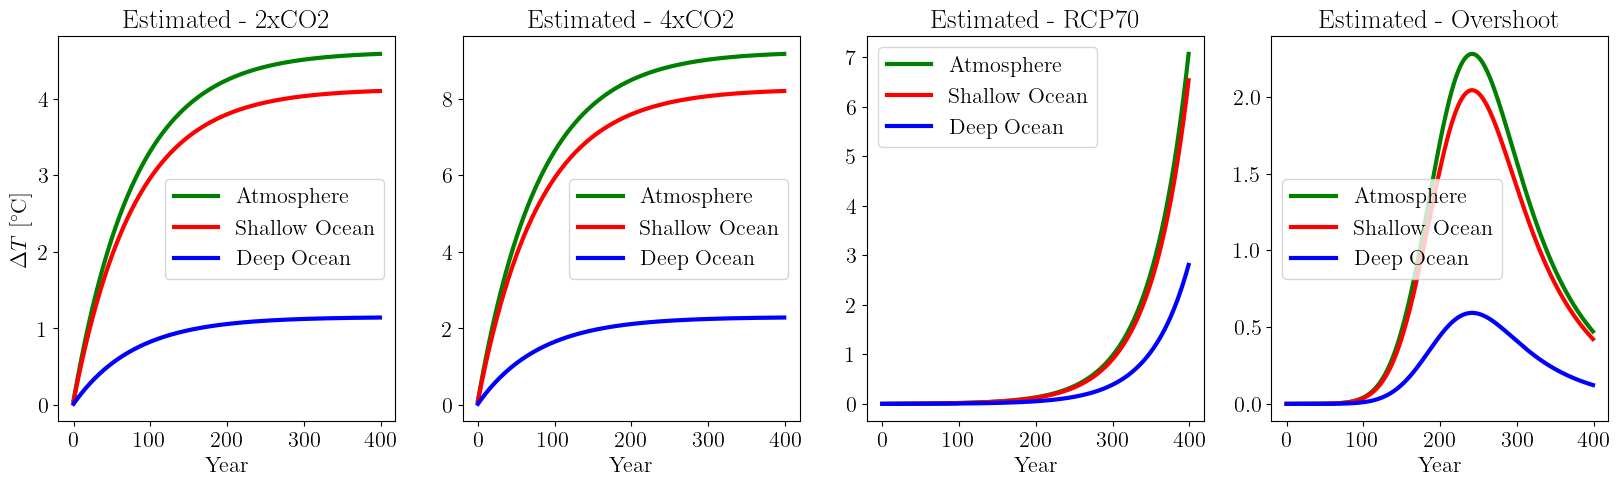

In [56]:
m = 1
k = 3
gamma = np.ones(k)

initial_v = np.random.rand(m * k)  # Flattened eigenvector
initial_lam = np.random.rand(m)      # Eigenvalues
initial_params = np.concatenate([initial_v, initial_lam])  # Combine into a single parameter vector
bounds = [(None, None)] * (m * k) + [(-1, 0)] * m

res_raw, res_modal = {}, {}
G_fit, a_fit = {}, {}

for exp in experiments:
  res_raw[exp] = minimize(response_utils.opt_v_lam_2D,
                                initial_params,
                                args=(T_analytic[exp], F_all[exp], t, m, dt, gamma),
                                method='L-BFGS-B',
                                bounds=bounds)

  G_fit[exp] = response_utils.apply_v_lam_2D(res_raw[exp].x, t, m, gamma)

T_est_raw_4, T_est_modal_4 = response_utils.estimate_T_2D(T_analytic, F_all,
                                                      experiments, t, 'G',
                                                      G_fit, a_deconv,
                                                      g_deconv, T0, dt)

response_utils.plot_box_model(T_est_raw_4, t, experiments, regions, colors, soln_type='Estimated', coupled=True)
L2_raw_4 = response_utils.calc_L2(T_analytic, T_est_raw_4, experiments, regions, 'Raw', coupled=True)


##### a.ii) Two leading order timescales

Error from Raw estimation.
	L2 Error, 2xCO2: 1.03123
	L2 Error, 4xCO2: 2.05434
	L2 Error, RCP70: 0.0015
	L2 Error, Overshoot: 0.31966
Avg. L2 Error: 0.85168



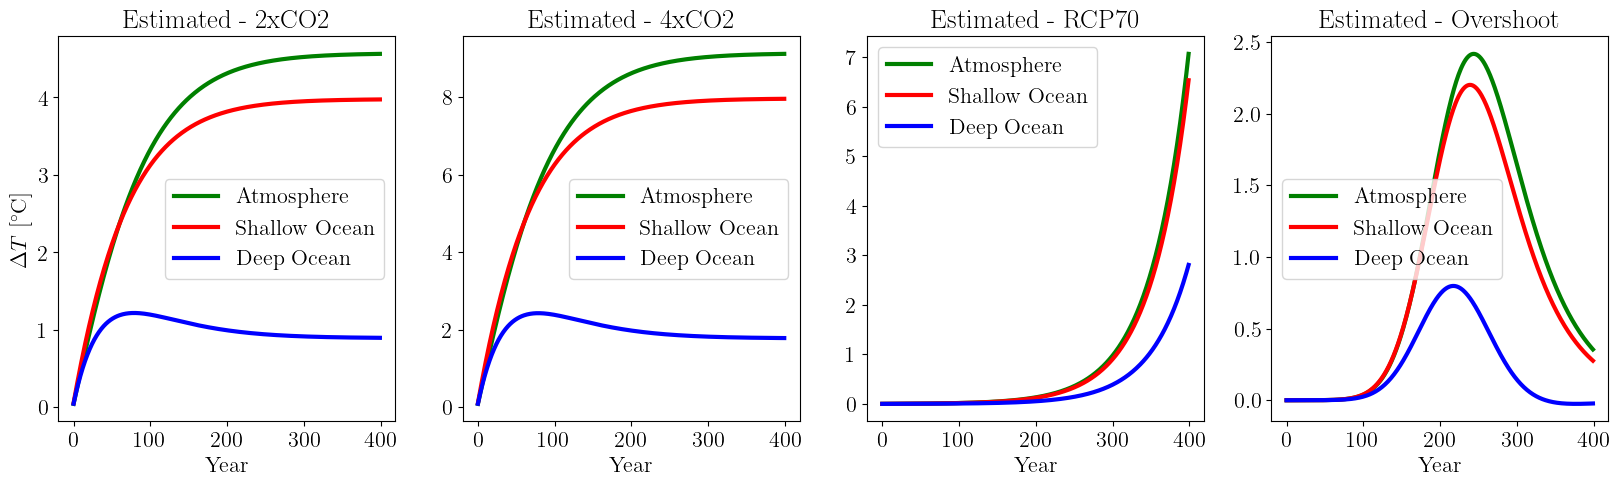

In [16]:
m = 2
k = 3
gamma = np.ones(k)

initial_v = np.random.rand(m * k)  # Flattened eigenvector
initial_lam = np.random.rand(m)      # Eigenvalues
initial_params = np.concatenate([initial_v, initial_lam])  # Combine into a single parameter vector
bounds = [(None, None)] * (m * k) + [(-1, 0)] * m

res_raw, res_modal = {}, {}
G_fit, a_fit = {}, {}

for exp in experiments:
  res_raw[exp] = minimize(response_utils.opt_v_lam_2D,
                                initial_params,
                                args=(T_analytic[exp], F_all[exp], t, m, dt, gamma),
                                method='L-BFGS-B',
                                bounds=bounds)

  G_fit[exp] = response_utils.apply_v_lam_2D(res_raw[exp].x, t, m, gamma)

T_est_raw_4, T_est_modal_4 = response_utils.estimate_T_2D(T_analytic, F_all,
                                                      experiments, t, 'G',
                                                      G_fit, a_deconv,
                                                      g_deconv, T0, dt)

response_utils.plot_box_model(T_est_raw_4, t, experiments, regions, colors, soln_type='Estimated', coupled=True)
L2_raw_4 = response_utils.calc_L2(T_analytic, T_est_raw_4, experiments, regions, 'Raw', coupled=True)


##### a.iii) All timescales

Error from Raw estimation.
	L2 Error, 2xCO2: 0.08538
	L2 Error, 4xCO2: 0.17969
	L2 Error, RCP70: 0.00543
	L2 Error, Overshoot: 0.05326
Avg. L2 Error: 0.08094



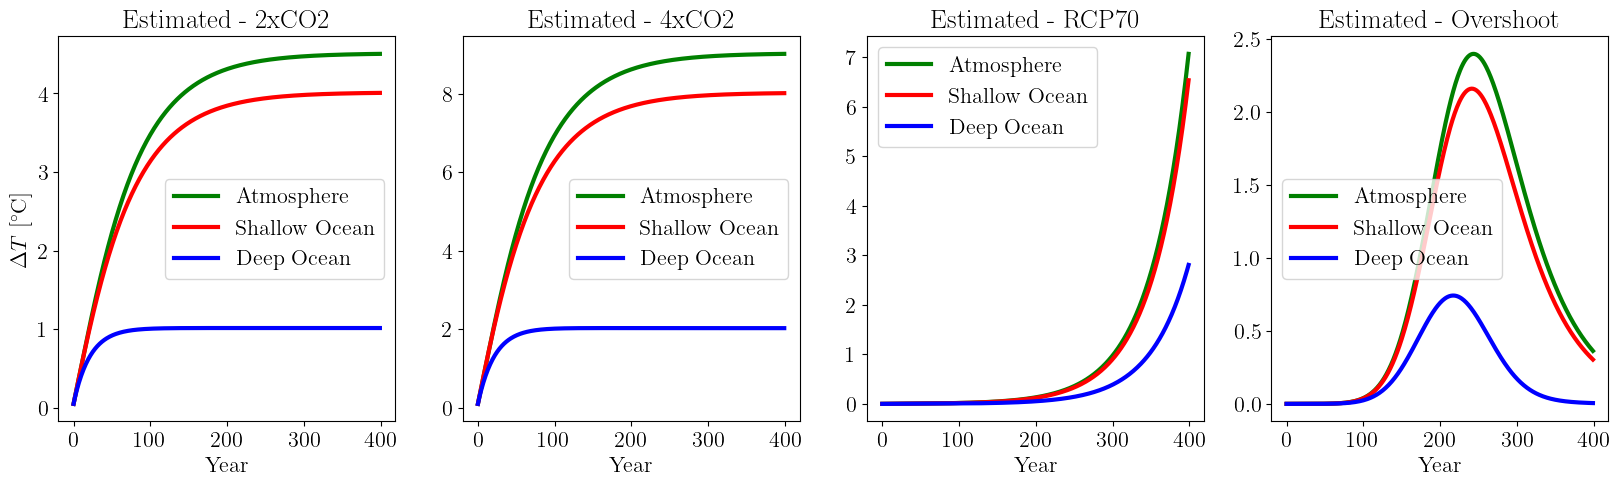

In [17]:
m = 3
k = 3
gamma = np.ones(k)

initial_v = np.random.rand(m * k)  # Flattened eigenvector
initial_lam = np.random.rand(m)      # Eigenvalues
initial_params = np.concatenate([initial_v, initial_lam])  # Combine into a single parameter vector
bounds = [(None, None)] * (m * k) + [(-1, 0)] * m

res_raw, res_modal = {}, {}
G_fit, a_fit = {}, {}

for exp in experiments:
  res_raw[exp] = minimize(response_utils.opt_v_lam_2D,
                                initial_params,
                                args=(T_analytic[exp], F_all[exp], t, m, dt, gamma),
                                method='L-BFGS-B',
                                bounds=bounds)

  G_fit[exp] = response_utils.apply_v_lam_2D(res_raw[exp].x, t, m, gamma)

T_est_raw_4, T_est_modal_4 = response_utils.estimate_T_2D(T_analytic, F_all,
                                                      experiments, t, 'G',
                                                      G_fit, a_deconv,
                                                      g_deconv, T0, dt)

response_utils.plot_box_model(T_est_raw_4, t, experiments, regions, colors, soln_type='Estimated', coupled=True)
L2_raw_4 = response_utils.calc_L2(T_analytic, T_est_raw_4, experiments, regions, 'Raw', coupled=True)


##### a.iv) Two timescales fit iteratively

Error from Raw estimation.
	L2 Error, 2xCO2: 0.46234
	L2 Error, 4xCO2: 0.31019
	L2 Error, RCP70: 0.00284
	L2 Error, Overshoot: 1.11304
Avg. L2 Error: 0.4721



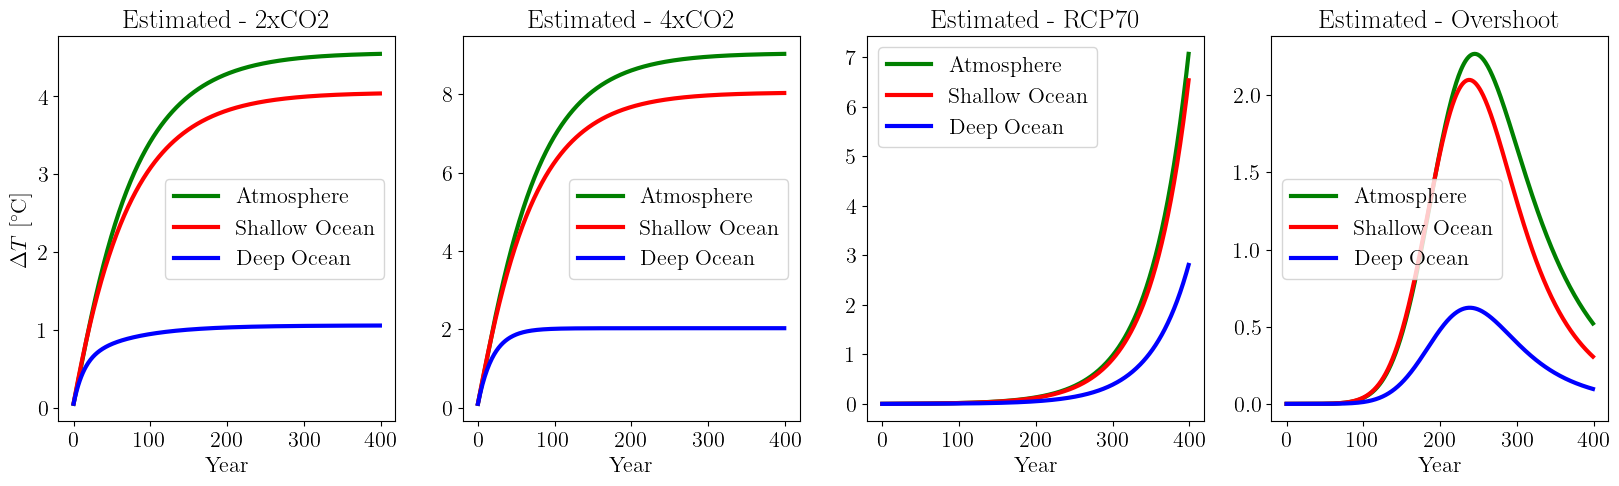

In [50]:
k = 3
gamma = np.ones(k)
n_final_modes = 2

initial_v = np.random.rand(k)  # Flattened eigenvector
initial_lam = np.random.rand(1)      # Eigenvalues

initial_params = {}
for exp in experiments:
  initial_params[exp] = np.concatenate([initial_v, initial_lam])  # Combine into a single parameter vector

bounds = [(None, None)] * (k) + [(-1, 0)]

res_raw, res_modal = {}, {}
G_fit, a_fit = {}, {}

for m in range(1, n_final_modes + 1):
  for exp in experiments:
    res_raw[exp] = minimize(response_utils.opt_v_lam_2D,
                                  initial_params[exp],
                                  args=(T_analytic[exp], F_all[exp], t, m, dt, gamma),
                                  method='L-BFGS-B',
                                  bounds=bounds)

    if m == n_final_modes:
      G_fit[exp] = response_utils.apply_v_lam_2D(res_raw[exp].x, t, m, gamma)

  for exp in experiments:
    if m != n_final_modes:
      initial_params[exp] = np.concatenate([res_raw[exp].x[:m*k], initial_v, res_raw[exp].x[m*k:], initial_lam])
      bounds = [(None, None)] * ((m + 1) * k) + [(-1, 0)] * (m + 1)

T_est_raw_5, T_est_modal_5 = response_utils.estimate_T_2D(T_analytic, F_all,
                                                      experiments, t, 'G',
                                                      G_fit, a_deconv,
                                                      g_deconv, T0, dt)

response_utils.plot_box_model(T_est_raw_5, t, experiments, regions, colors, soln_type='Estimated', coupled=True)
L2_raw_5 = response_utils.calc_L2(T_analytic, T_est_raw_5, experiments, regions, 'Raw', coupled=True)


##### a.v) All timescales fit iteratively

Error from Raw estimation.
	L2 Error, 2xCO2: 0.6407
	L2 Error, 4xCO2: 0.30949
	L2 Error, RCP70: 2.35048
	L2 Error, Overshoot: 0.12345
Avg. L2 Error: 0.85603



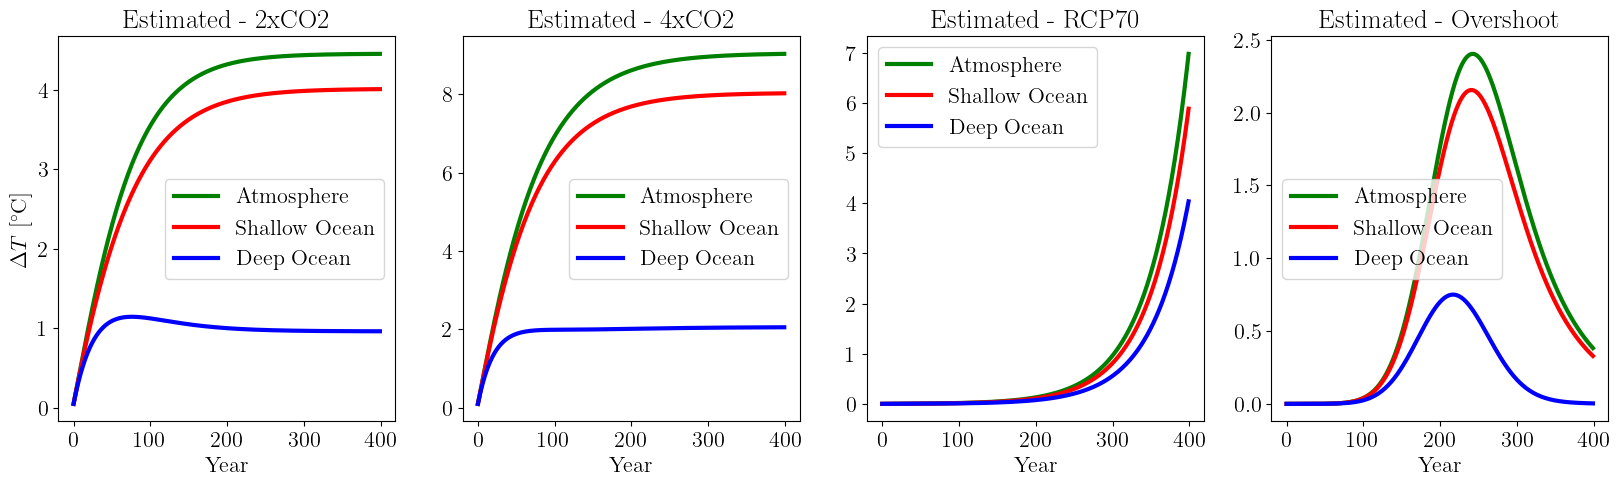

In [55]:
k = 3
gamma = np.ones(k)
n_final_modes = 3

initial_v = np.random.rand(k)  # Flattened eigenvector
initial_lam = -np.random.rand(1)      # Eigenvalues

initial_params = {}
for exp in experiments:
  initial_params[exp] = np.concatenate([initial_v, initial_lam])  # Combine into a single parameter vector

bounds = [(None, None)] * (k) + [(-1, 0)]

res_raw, res_modal = {}, {}
G_fit, a_fit = {}, {}

for m in range(1, n_final_modes + 1):
  for exp in experiments:
    res_raw[exp] = minimize(response_utils.opt_v_lam_2D,
                                  initial_params[exp],
                                  args=(T_analytic[exp], F_all[exp], t, m, dt, gamma),
                                  method='L-BFGS-B',
                                  bounds=bounds)

    if m == n_final_modes:
      G_fit[exp] = response_utils.apply_v_lam_2D(res_raw[exp].x, t, m, gamma)

  for exp in experiments:
    if m != n_final_modes:
      initial_params[exp] = np.concatenate([res_raw[exp].x[:m*k], initial_v, res_raw[exp].x[m*k:], initial_lam])
      bounds = [(None, None)] * ((m + 1) * k) + [(-1, 0)] * (m + 1)

T_est_raw_5, T_est_modal_5 = response_utils.estimate_T_2D(T_analytic, F_all,
                                                      experiments, t, 'G',
                                                      G_fit, a_deconv,
                                                      g_deconv, T0, dt)

response_utils.plot_box_model(T_est_raw_5, t, experiments, regions, colors, soln_type='Estimated', coupled=True)
L2_raw_5 = response_utils.calc_L2(T_analytic, T_est_raw_5, experiments, regions, 'Raw', coupled=True)


##### b) With noise